In [ ]:
"""
Restricted Boltzmann Machine (RBM) - implementation.
This notebook keeps a readable, minimally-vectorized RBM that mirrors the
BoltzmannMachine notebook's learning flow but uses bipartite (visible<->hidden)
connections only (no visible-visible or hidden-hidden weights).
"""
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [ ]:
# Configuration (concise)
IMAGE_CROP = 2              # pixels cropped from each border (28 -> 28-2*IMAGE_CROP)
DIGITS = [4]                # which digit classes to sample from (changeable list)
N_TRAIN = 500               # how many images to use (sampled without replacement)

# Load MNIST and crop to match Hopfield notebook preprocessing
(X_train, y_train), _ = mnist.load_data()
X_train = X_train[:, IMAGE_CROP:-IMAGE_CROP, IMAGE_CROP:-IMAGE_CROP].astype('float32') / 255.0
IMAGE_SIZE = X_train.shape[1]

# Create a local RNG for reproducible / isolated sampling
rng = np.random.default_rng()

# Select candidate images for the requested digits
candidate_idx = np.where(np.isin(y_train, DIGITS))[0]

# Randomly sample up to N_TRAIN indices from the candidates using the local RNG
sel_pos = rng.choice(candidate_idx.size, size=min(N_TRAIN, candidate_idx.size), replace=False)
selected_idx = candidate_idx[sel_pos]            # indices in the original dataset
selected_images = X_train[selected_idx]          # grayscale float images in [0,1]
selected_labels = y_train[selected_idx]          # corresponding labels

# Binarize each image by its own mean (visible units will be 0/1 for RBM)
image_means = selected_images.mean(axis=(1,2), keepdims=True)
training_patterns = (selected_images > image_means).astype(np.float32)

print(f"Selected {training_patterns.shape[0]} images for digits {DIGITS}")
print(f"Each sample has {IMAGE_SIZE}x{IMAGE_SIZE} visible units")

Selected 500 images for digits [4]
Each sample has 24x24 visible units


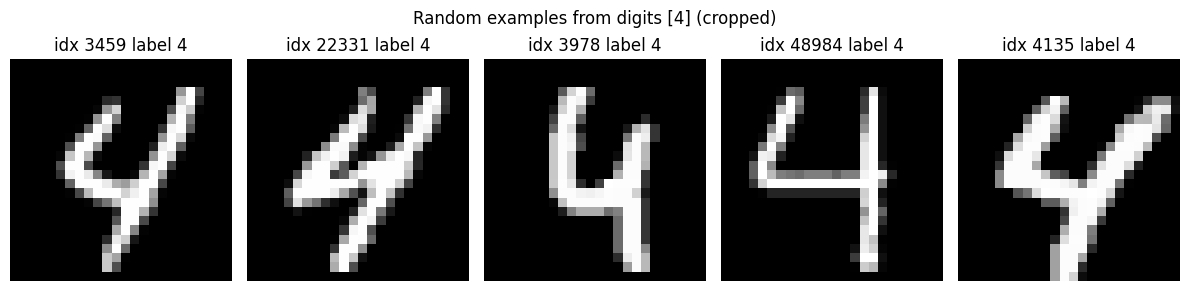

In [ ]:
# Show up to 5 examples from the selected set so users can inspect data
n_show = min(5, selected_images.shape[0])
sel = rng.choice(selected_images.shape[0], size=n_show, replace=False)   # use the same rng
fig, axes = plt.subplots(1, n_show, figsize=(12, 3))
for i, idx in enumerate(sel):
    axes[i].imshow(selected_images[idx], cmap='gray', interpolation='nearest')
    axes[i].set_title(f"idx {selected_idx[idx]} label {selected_labels[idx]}")
    axes[i].axis('off')
plt.suptitle(f"Random examples from digits {DIGITS} (cropped)")
plt.tight_layout()
plt.show()

In [ ]:
class Neuron:
    """
    Lightweight per-unit wrapper that delegates storage to the RBM arrays.
    Attribute-style access reads/writes vectors in the RBM instance.
    """
    def __init__(self, index, layer, rbm):
        # layer: 'v' for visible, 'h' for hidden
        self.index = index
        self.layer = layer
        self.rbm = rbm

    @property
    def state(self):
        # Return the current state from the RBM's vector storage (0.0 or 1.0)
        return float(self.rbm.v[self.index]) if self.layer == 'v' else float(self.rbm.h[self.index])

    @state.setter
    def state(self, value):
        # Write back into the RBM arrays; keeps wrappers consistent with vectors
        if self.layer == 'v':
            self.rbm.v[self.index] = float(value)
        else:
            self.rbm.h[self.index] = float(value)

    def activate(self, x):
        # Reuse RBM's sigmoid for numerical stability
        return self.rbm.sigmoid(x)

    def sample_state(self, input_sum):
        # Sample a binary state using the RBM's RNG (probabilistic)
        p = self.activate(input_sum)
        s = 1.0 if self.rbm.rng.random() < p else 0.0
        self.state = s
        return s

In [ ]:
class RBM:
    """
    Restricted Boltzmann Machine (visible <-> hidden only).
    Vectorized operations used for learning (contrastive divergence).
    """
    def __init__(self, n_visible, n_hidden, learning_rate=0.01, rng=None):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # RNG for this RBM instance
        self.rng = np.random.default_rng() if rng is None else rng

        # Weight matrix: visible-to-hidden (n_visible x n_hidden).
        self.W = self.rng.normal(0, 0.01, (n_visible, n_hidden))

        # Bias vectors for visible and hidden layers
        self.v_bias = np.zeros(n_visible, dtype=float)
        self.h_bias = np.zeros(n_hidden, dtype=float)

        # State vectors for visible and hidden units (kept as floats 0/1)
        self.v = np.zeros(n_visible, dtype=float)
        self.h = np.zeros(n_hidden, dtype=float)

        # Create neuron wrappers (keeps API similar to full Boltzmann implementation)
        self.neurons = []
        for i in range(n_visible):
            self.neurons.append(Neuron(i, 'v', self))
        for j in range(n_hidden):
            self.neurons.append(Neuron(j, 'h', self))

    def sigmoid(self, x):
        # Numerically-stable sigmoid using clipping
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

    def sample_hidden(self, v):
        """Compute hidden-unit probabilities and binary samples given visible v."""
        h_act = np.dot(v, self.W) + self.h_bias         # pre-activation for hidden units
        h_prob = self.sigmoid(h_act)                    # probabilities p(h=1|v)
        h_sample = (self.rng.random(self.n_hidden) < h_prob).astype(float)
        self.h[:] = h_sample                            # update vector state
        # keep wrappers in sync for inspection
        for j in range(self.n_hidden):
            self.neurons[self.n_visible + j].state = h_sample[j]
        return h_prob, h_sample

    def sample_visible(self, h):
        """Compute visible-unit probabilities and binary samples given hidden h."""
        v_act = np.dot(h, self.W.T) + self.v_bias       # pre-activation for visible units
        v_prob = self.sigmoid(v_act)                    # probabilities p(v=1|h)
        v_sample = (self.rng.random(self.n_visible) < v_prob).astype(float)
        self.v[:] = v_sample
        for i in range(self.n_visible):
            self.neurons[i].state = v_sample[i]
        return v_prob, v_sample

    def contrastive_divergence(self, v_data, k=1):
        """Perform a CD-k update using v_data (single data vector).
        Steps:
          1) Positive phase: clamp v=v_data, compute h probabilities
          2) Negative phase: Gibbs sample for k steps to get model statistics
          3) Update W, v_bias, h_bias with pos-neg differences
        """
        v0 = np.array(v_data, dtype=float)
        # positive phase
        self.v[:] = v0
        for i in range(self.n_visible):
            self.neurons[i].state = v0[i]
        h0_prob, h0_sample = self.sample_hidden(v0)

        # negative phase (Gibbs chain starting from h0_sample)
        h = h0_sample.copy()
        for _ in range(k):
            v_prob, v_sample = self.sample_visible(h)
            h_prob, h = self.sample_hidden(v_sample)

        # gradients (outer products are standard RBM updates)
        pos_grad = np.outer(v0, h0_prob)
        neg_grad = np.outer(v_prob, h_prob)

        # parameter updates (small learning rate recommended for demos)
        self.W += self.learning_rate * (pos_grad - neg_grad)
        self.v_bias += self.learning_rate * (v0 - v_prob)
        self.h_bias += self.learning_rate * (h0_prob - h_prob)

    def free_energy(self, v):
        """Compute the RBM free energy of a visible vector v."""
        v = np.array(v, dtype=float).flatten()
        wx_b = self.h_bias + np.dot(v, self.W)   # W^T v + h_bias
        hidden_term = np.sum(np.log1p(np.exp(wx_b)))  # log(1+exp(.)) stable form
        vis_term = -np.dot(v, self.v_bias)
        return float(vis_term - hidden_term)

    def gibbs_sample(self, steps=50, track_energy=False):
        """
        Generate a visible sample by alternating visible<->hidden updates.
        If track_energy=True returns (v, energy_history).
        """
        # initialize visible random binary state using the instance RNG
        self.v[:] = (self.rng.random(self.n_visible) < 0.5).astype(float)
        for i in range(self.n_visible):
            self.neurons[i].state = self.v[i]

        energy_history = [] if track_energy else None
        if track_energy:
            energy_history.append(self.free_energy(self.v))

        for _ in range(steps):
            _, h = self.sample_hidden(self.v)
            _, v = self.sample_visible(h)
            if track_energy:
                energy_history.append(self.free_energy(self.v))

        if track_energy:
            return self.v.copy(), energy_history
        return self.v.copy()

In [ ]:
# Training loop (CD-1 by default) - use the same rng for shuffling
n_visible = IMAGE_SIZE * IMAGE_SIZE
n_hidden = 128               # number of hidden units (tuneable)
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=0.01, rng=rng)

n_epochs = 50                # number of passes over the data
n_samples_per_epoch = min(1000, training_patterns.shape[0])

# Flatten the training patterns (each is 0/1) for CD updates
training_data = training_patterns.reshape(training_patterns.shape[0], -1).astype(np.float32)

for epoch in range(n_epochs):
    # shuffle indices each epoch using the instance RNG to avoid ordering effects
    indices = rng.permutation(training_data.shape[0])
    for idx in indices[:n_samples_per_epoch]:
        data = training_data[idx]
        rbm.contrastive_divergence(data, k=1)   # CD-1
    print(f"Epoch {epoch+1}/{n_epochs} complete (trained on {training_data.shape[0]} samples)")

Epoch 1/50 complete (trained on 500 samples)
Epoch 2/50 complete (trained on 500 samples)
Epoch 2/50 complete (trained on 500 samples)
Epoch 3/50 complete (trained on 500 samples)
Epoch 3/50 complete (trained on 500 samples)
Epoch 4/50 complete (trained on 500 samples)
Epoch 4/50 complete (trained on 500 samples)
Epoch 5/50 complete (trained on 500 samples)
Epoch 5/50 complete (trained on 500 samples)
Epoch 6/50 complete (trained on 500 samples)
Epoch 6/50 complete (trained on 500 samples)
Epoch 7/50 complete (trained on 500 samples)
Epoch 7/50 complete (trained on 500 samples)
Epoch 8/50 complete (trained on 500 samples)
Epoch 8/50 complete (trained on 500 samples)
Epoch 9/50 complete (trained on 500 samples)
Epoch 9/50 complete (trained on 500 samples)
Epoch 10/50 complete (trained on 500 samples)
Epoch 10/50 complete (trained on 500 samples)
Epoch 11/50 complete (trained on 500 samples)
Epoch 11/50 complete (trained on 500 samples)
Epoch 12/50 complete (trained on 500 samples)
Epoch

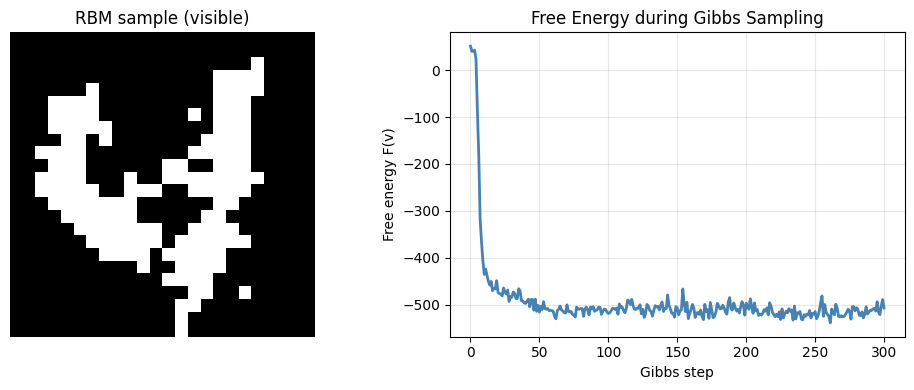

In [ ]:
def sample_from_rbm(rbm, steps=500, track_energy=False):
    """Helper: run gibbs_sample and optionally return energy history."""
    out = rbm.gibbs_sample(steps=steps, track_energy=track_energy)
    return out

# Single-sample with free-energy tracking and plot (diagnostic)
sample, energy_history = sample_from_rbm(rbm, steps=300, track_energy=True)
sample_img = sample.reshape(IMAGE_SIZE, IMAGE_SIZE)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(sample_img, cmap='gray', interpolation='nearest')
ax1.axis('off')
ax1.set_title('RBM sample (visible)')

ax2.plot(energy_history, linewidth=2, color='steelblue')
ax2.set_xlabel('Gibbs step')
ax2.set_ylabel('Free energy F(v)')
ax2.set_title('Free Energy during Gibbs Sampling')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

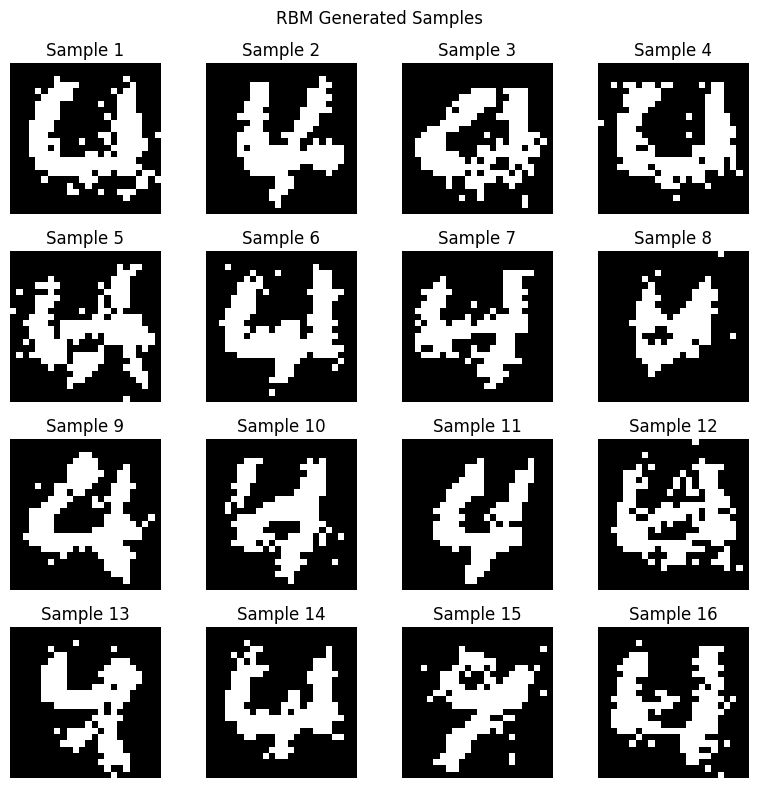

In [8]:
# Generate multiple samples (small grid) — useful to compare model outputs
n_samples_to_show = min(16, training_data.shape[0])
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
for i in range(n_samples_to_show):
    sample = sample_from_rbm(rbm, steps=100)
    sample_img = sample.reshape(IMAGE_SIZE, IMAGE_SIZE)
    axes[i].imshow(sample_img, cmap='gray', interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')
plt.suptitle('RBM Generated Samples')
plt.tight_layout()
plt.show()